In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from transformers import ViTImageProcessor, ViTForImageClassification

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

2025-03-08 03:01:14.476969: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-08 03:01:14.485843: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741381274.496298  116118 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741381274.499484  116118 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-08 03:01:14.510456: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Using device: cuda


In [2]:
dataset_path = "datasets/FF++"
REAL_PATH = os.path.join(dataset_path, "real")
FAKE_PATH = os.path.join(dataset_path, "fake")
OUTPUT_FRAME_SIZE = (128, 128)
FRAME_COUNT = 10
MAX_VIDEOS = 200

def extract_frames(video_path, output_size=(128, 128), frame_count=10):
    """Extract a fixed number of frames from a video."""
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(total_frames // frame_count, 1)
    
    for i in range(frame_count):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, output_size)
        frames.append(frame)  # uint8 numpy array
    cap.release()
    return frames if len(frames) == frame_count else None

# Collect data
data = []
labels = []

# Real videos
print("Processing real videos...")
for video_file in tqdm(os.listdir(REAL_PATH)[:MAX_VIDEOS]):
    video_path = os.path.join(REAL_PATH, video_file)
    frames = extract_frames(video_path, OUTPUT_FRAME_SIZE, FRAME_COUNT)
    if frames:
        data.append(frames)
        labels.append(0)  # 0 for real

# Fake videos
print("Processing fake videos...")
for video_file in tqdm(os.listdir(FAKE_PATH)[:MAX_VIDEOS]):
    video_path = os.path.join(FAKE_PATH, video_file)
    frames = extract_frames(video_path, OUTPUT_FRAME_SIZE, FRAME_COUNT)
    if frames:
        data.append(frames)
        labels.append(1)  # 1 for fake

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train samples: {len(X_train)}, Val samples: {len(X_val)}, Test samples: {len(X_test)}")

Processing real videos...


100%|██████████| 200/200 [02:07<00:00,  1.56it/s]


Processing fake videos...


100%|██████████| 200/200 [02:05<00:00,  1.59it/s]

Train samples: 280, Val samples: 60, Test samples: 60


In [3]:
# Load processor and model
model_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)

In [4]:
# Enhanced augmentation
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.Resize((224, 224)),  # Match ViT’s expected size
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std)])

class VideoDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data  # List of video sequences
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sequence = self.data[idx]  # List of frames
        label = self.labels[idx]
        sequence = [self.transform(frame) for frame in sequence]
        sequence = torch.stack(sequence)  # Shape: (seq_len, 3, 224, 224), e.g., (10, 3, 224, 224)
        return sequence, torch.tensor(label, dtype=torch.long)

# Create datasets and loaders
batch_size = 10
train_dataset = VideoDataset(X_train, y_train, train_transform)
val_dataset = VideoDataset(X_val, y_val, val_transform)
test_dataset = VideoDataset(X_test, y_test, val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [5]:
# Load pre-trained ViT with a binary classification head (adjust num_labels as needed)
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=2,  # Use 10 if you have 10 classes
    ignore_mismatched_sizes=True
)

model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [6]:
class VideoClassifier(nn.Module):
    def __init__(self, vit_model):
        super().__init__()
        self.vit = vit_model.vit  # Use the ViT backbone (excludes the original head)
        self.lstm = nn.LSTM(input_size=768, hidden_size=64, batch_first=True)  # 768 is ViT-base’s embedding size
        self.fc = nn.Linear(64, 2)  # Adjust to 10 for 10 classes
    
    def forward(self, x):
        batch_size, seq_len, C, H, W = x.size()  # e.g., (batch, 10, 3, 224, 224)
        x = x.view(batch_size * seq_len, C, H, W)  # Flatten batch and sequence
        x = self.vit(x).last_hidden_state[:, 0, :]  # Get [CLS] token embeddings: (batch*seq_len, 768)
        x = x.view(batch_size, seq_len, 768)  # Reshape for LSTM
        x, _ = self.lstm(x)  # Process sequence
        x = self.fc(x[:, -1, :])  # Use last LSTM output for classification
        return x

# Initialize the video model
video_model = VideoClassifier(model).to(device)

In [7]:
optimizer = torch.optim.AdamW(video_model.parameters(), lr=1e-4, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

In [8]:
for param in video_model.vit.parameters():
    param.requires_grad = False  # Freeze ViT backbone

In [9]:
num_epochs = 12

# Write the training loop with tqdm for visualizing progress and it will contain train and validation steps with accuracy and both losses
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training
    video_model.train()
    train_loss = 0.0
    for i, (inputs, labels) in enumerate(tqdm(train_loader)):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = video_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validation
    video_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(val_loader)):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = video_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

100%|██████████| 6/6 [00:02<00:00,  2.84it/s]


Epoch 1/12, Train Loss: 0.7074, Val Loss: 0.6957, Val Acc: 0.5000


100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


Epoch 2/12, Train Loss: 0.6833, Val Loss: 0.6911, Val Acc: 0.4833


100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


Epoch 3/12, Train Loss: 0.6773, Val Loss: 0.6865, Val Acc: 0.5000


100%|██████████| 6/6 [00:02<00:00,  2.96it/s]


Epoch 4/12, Train Loss: 0.6622, Val Loss: 0.6813, Val Acc: 0.5833


100%|██████████| 6/6 [00:02<00:00,  2.90it/s]


Epoch 5/12, Train Loss: 0.6580, Val Loss: 0.6783, Val Acc: 0.5667


100%|██████████| 6/6 [00:02<00:00,  2.94it/s]


Epoch 6/12, Train Loss: 0.6440, Val Loss: 0.6769, Val Acc: 0.6000


100%|██████████| 6/6 [00:02<00:00,  2.93it/s]


Epoch 7/12, Train Loss: 0.6342, Val Loss: 0.6718, Val Acc: 0.5833


100%|██████████| 6/6 [00:02<00:00,  2.92it/s]


Epoch 8/12, Train Loss: 0.6227, Val Loss: 0.6712, Val Acc: 0.5833


100%|██████████| 6/6 [00:02<00:00,  2.91it/s]


Epoch 9/12, Train Loss: 0.6113, Val Loss: 0.6730, Val Acc: 0.5833


100%|██████████| 6/6 [00:02<00:00,  2.93it/s]


Epoch 10/12, Train Loss: 0.6041, Val Loss: 0.6705, Val Acc: 0.5500


100%|██████████| 6/6 [00:02<00:00,  2.94it/s]


Epoch 11/12, Train Loss: 0.5901, Val Loss: 0.6698, Val Acc: 0.5833


100%|██████████| 6/6 [00:02<00:00,  2.91it/s]

Epoch 12/12, Train Loss: 0.5927, Val Loss: 0.6685, Val Acc: 0.5667


In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating Test Set"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss /= len(test_loader)
    test_acc = accuracy_score(all_labels, all_preds)
    return test_loss, test_acc, all_preds, all_labels

# Evaluate the model
test_loss, test_acc, test_preds, test_labels = evaluate_model(video_model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Evaluating Test Set: 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]

Test Loss: 0.6473, Test Accuracy: 0.6333


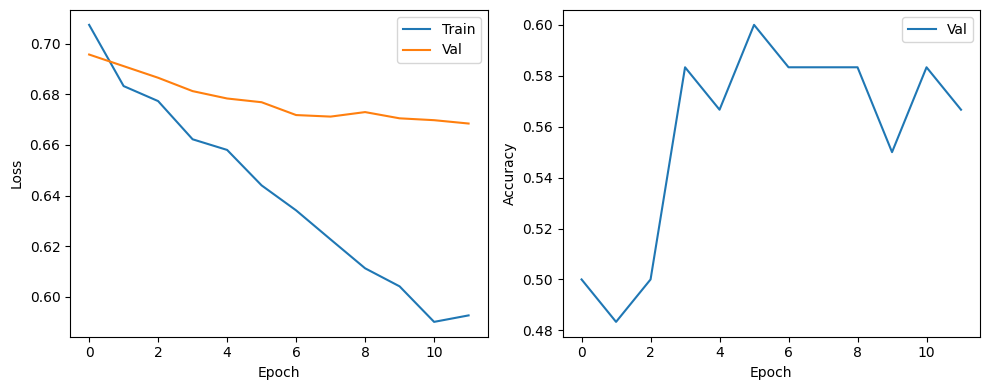

In [11]:
# Plot losses and accuracies
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


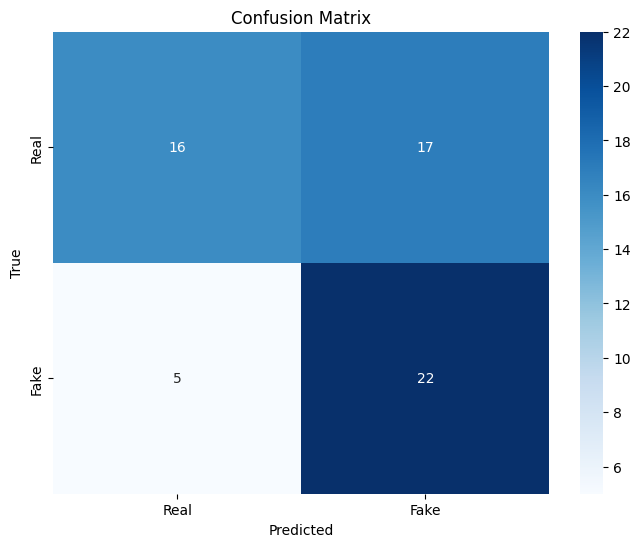

In [16]:
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, class_names=['Real', 'Fake']):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(test_labels, test_preds)

In [17]:
def print_classification_report(y_true, y_pred, class_names=['Real', 'Fake']):
    report = classification_report(y_true, y_pred, target_names=class_names)
    print("Classification Report:")
    print(report)

# Print classification report
print_classification_report(test_labels, test_preds)

Classification Report:
              precision    recall  f1-score   support

        Real       0.76      0.48      0.59        33
        Fake       0.56      0.81      0.67        27

    accuracy                           0.63        60
   macro avg       0.66      0.65      0.63        60
weighted avg       0.67      0.63      0.63        60



In [18]:
model_path = "models/video_classifier.pth"
torch.save(video_model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to models/video_classifier.pth
